In [2]:
import pandas as pd
#import geopandas as gpd
import requests
import rasterio as rio
from rasterio.plot import show
from rasterio.warp import transform
from rasterio.transform import (xy, rowcol)
from rasterio.windows import Window
import itertools as it
import rioxarray as rx
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from pathlib import Path
import time
import timeit
import os.path
import math
from string import Template

from typing import Tuple, Optional, List

from leaf.deforestation import (
    cache_earthenginepartners_hansen,
    earthenginepartners_hansen)

import cartopy.crs as ccrs
import cartopy.feature as cfeature


In [3]:
df = pd.read_csv('data/assets_for_deforestation.csv', sep='\t')
df.country.value_counts().head()

country
China            10314
United States     1711
Germany           1673
India             1325
France            1007
Name: count, dtype: int64

In [4]:
# spanning the range 180W-180E and 80N-60S
# 80N, 70N, ... 10N, 00N, 10S, 20S, ... 50S - 180W
# 80N - 180W, 170W, ... 010W, 000E, 010E.... 170E

# https://worldpopulationreview.com/country-rankings/deforestation-rates-by-country
# https://gist.github.com/graydon/11198540
# long lat bottom left, long lat top right
country_bounding_boxes = {
    'BR': ('Brazil', (-73.9872354804, -33.7683777809, -34.7299934555, 5.24448639569)),
    'ID': ('Indonesia', (95.2930261576, -10.3599874813, 141.03385176, 5.47982086834)),
    'CD': ('Congo (Kinshasa)', (12.1823368669, -13.2572266578, 31.1741492042, 5.25608775474)),
    'AO': ('Angola', (11.6400960629, -17.9306364885, 24.0799052263, -4.43802336998)),
    #Tazmania
    'MM': ('Myanmar', (92.3032344909, 9.93295990645, 101.180005324, 28.335945136)),
    #'PY': ('Paraguay', (-62.6850571357, -27.5484990374, -54.2929595608, -19.3427466773)),
    #'BO': ('Bolivia', (-69.5904237535, -22.8729187965, -57.4983711412, -9.76198780685)),
    'MZ': ('Mozambique', (30.1794812355, -26.7421916643, 40.7754752948, -10.3170960425)),
    'AR': ('Argentina', (-73.4154357571, -55.25, -53.628348965, -21.8323104794)),
    'AU': ('Australia', (113.338953078, -43.6345972634, 153.569469029, -10.6681857235)),
    'VN': ('Vietnam', (102.170435826, 8.59975962975, 109.33526981, 23.3520633001)),
    'PE': ('Peru', (-81.4109425524, -18.3479753557, -68.6650797187, -0.0572054988649)),
    'PG': ('Papua New Guinea', (141.000210403, -10.6524760881, 156.019965448, -2.50000212973)),
    'PH': ('Philippines', (117.17427453, 5.58100332277, 126.537423944, 18.5052273625)),
    'CO': ('Colombia', (-78.9909352282, -4.29818694419, -66.8763258531, 12.4373031682)),
    # Note bene: Low in ranking but high in assets...
    'CN': ('China', (73.6753792663, 18.197700914, 135.026311477, 53.4588044297)),
    'US': ('United States', (-171.791110603, 18.91619, -66.96466, 71.3577635769)),
}

country_bounding_boxes_adds = {
}

def ranges(bboxes, country_code: str, step = 10) -> Tuple[range, range]:
    country = bboxes[country_code]
    temp = tuple(map(lambda x: math.ceil(x), country[1]))
    latitudes = range(temp[1], temp[3], step)
    longitudes = range(temp[0], temp[2], step)
    ranges = (latitudes, longitudes)
    return ranges

def rectangle(bboxes, country_code: str) -> Rectangle:
    country = bboxes[country_code]
    temp = tuple(map(lambda x: math.ceil(x), country[1]))
    rectangle = Rectangle(xy=(temp[0], temp[1]),
                          width=abs(temp[2] - temp[0]), height=abs(temp[3] - temp[1]),
                          linewidth=1, color='red', fill=False)
    return rectangle


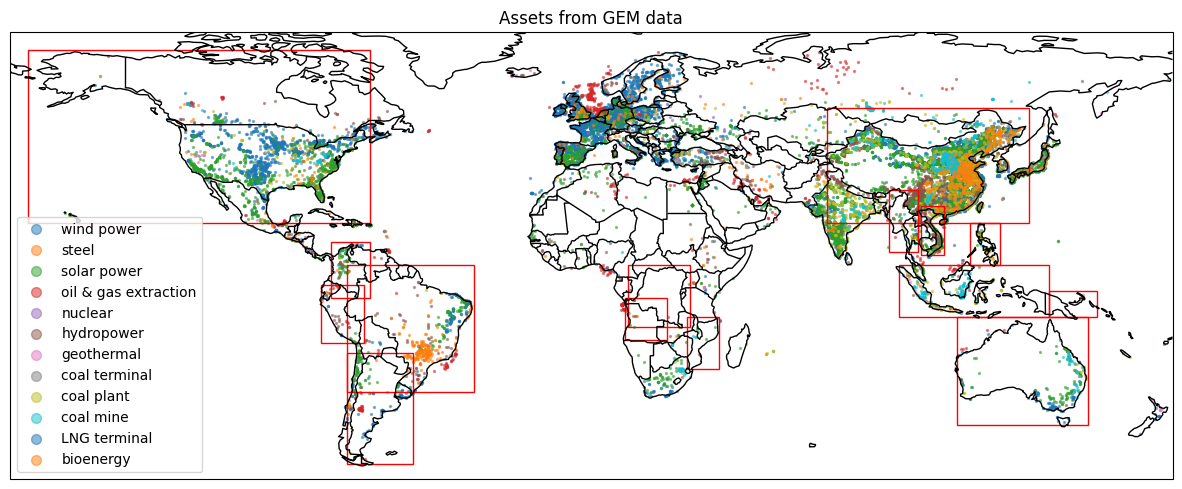

In [7]:
# Create a map of areas of interest
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

#ax.set_extent([-73, -35, -33, 6])  # Define the extent of the map (lon_min, lon_max, lat_min, lat_max)

# Plot assets

for sector_main in df.sector_main.unique():
    foo = df[df.sector_main == sector_main]
    ax.scatter(foo['longitude'], foo['latitude'],
        marker='o', 
        s=2, alpha = 0.5, label=sector_main,
        transform=ccrs.PlateCarree())

codes = [code for code, _ in country_bounding_boxes.items()]
for code in codes:
    ax.add_patch(rectangle(country_bounding_boxes, code))

# Add map features
ax.coastlines()

# Add country borders
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1)

# Add title and labels
plt.title('Assets from GEM data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

ax.legend(markerscale=5)

# Show the plot
plt.show()

# save the plot
fig.savefig('graphs/map_assets_all.png', bbox_inches='tight')

In [ ]:
# Nota bene: Robert Norris - this will re-create assets_with_deforestation.csv from 
# assets_for_deforestation.csv, using whatever countries have been included in 
# country_bounding_boxes. Any additionally required GeoTIFF files from the Hansen 
# dataset will be downloaded and cached. It uses the default offset of 16 to inspect 
# an region 990m x 990m centred on each asset.

brazil = ranges(country_bounding_boxes, 'BR')
earthenginepartners_hansen('data/assets_for_deforestation.csv', '\t', 
                           brazil[0], brazil[1],
                           'data/assets_with_deforestation.csv', verbose=False)

remaining_country_codes = [code for code in country_bounding_boxes.keys() if code != 'BR']
for code in remaining_country_codes:
    country_ranges = ranges(country_bounding_boxes, code)
    earthenginepartners_hansen('data/assets_with_deforestation.csv', '\t', 
                               country_ranges[0], country_ranges[1],
                               'data/assets_with_deforestation.csv', verbose=False)


In [ ]:
country_codes = [code for code in country_bounding_boxes_adds.keys()]
for code in country_codes:
    country_ranges = ranges(country_bounding_boxes, code)
    earthenginepartners_hansen('data/assets_with_deforestation.csv', '\t', 
                               country_ranges[0], country_ranges[1],
                               'data/assets_with_deforestation.csv', verbose=False)

In [ ]:
# Nota bene: Robert Norris - this will re-create assets_with_deforestation_n.csv 
# where n is the dimension in metres, from assets_for_deforestation.csv, using whatever countries have 
# been included in country_bounding_boxes. Any additionally required GeoTIFF files from the Hansen 
# dataset will be downloaded and cached. Increasing the size may ignore more assets at the borders
# of each GeoTIFF but more of the surrounding area will be considered per asset.

for offset in [32, 48, 80, 128]:

    dimension = (offset * 2 + 1) * 30 # each pixel is ~30m x 30m
    GEMFile = f'data/assets_with_deforestation_{dimension}.csv'

    brazil = ranges(country_bounding_boxes, 'BR')
    earthenginepartners_hansen('data/assets_for_deforestation.csv', '\t', 
                            brazil[0], brazil[1],
                            GEMFile, offset, verbose=False)

    remaining_country_codes = [code for code in country_bounding_boxes.keys() if code != 'BR']
    for code in remaining_country_codes:
        country_ranges = ranges(country_bounding_boxes, code)
        earthenginepartners_hansen(GEMFile, '\t', 
                                country_ranges[0], country_ranges[1],
                                GEMFile, offset, verbose=False)


In [ ]:
import missingno as msno

df = pd.read_csv('data/assets_with_deforestation.csv', sep='\t')
msno.bar(df)
# len(f"Number of valid observations: {df[df['2022'] >= 0]}")

In [ ]:
countries = [country[0] for code, country in country_bounding_boxes.items()]
for country in countries:
    value_counts = df[df.treecover2000.notna() & (df.country == country)].sector_main.value_counts()
    print(f'{country}\n{value_counts}\n')

In [ ]:
lossyears = [str(lossyear) for lossyear in range(2001, 2023)]
countries = [country[0] for code, country in country_bounding_boxes.items()]
with pd.option_context('expand_frame_repr', False):
    for country in countries:
        print(country)
        print(df[(df[lossyears] > 0).any(axis=1) & (df.country == country)].head(2))


In [ ]:
df[(df[lossyears] > 0).any(axis=1)].country.value_counts()

In [ ]:
msno.heatmap(df)

In [ ]:
df = pd.read_csv('data/regression_sample.csv', sep='\t')
#df.country.value_counts().head(10)
#df[df.country == 'Brazil'].head()
